In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27 # figure size in inches

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 30) 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config Completer.use_jedi = False

import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from IPython.display import display


In [2]:
df_daybin = pd.read_csv('CSV/df_daybin_4.csv')

In [3]:
# Preprocess data

# Select categorical columns
categorical_cols = ['race', 'gender']

# Select numerical columns
numerical_cols = ['sbp', 'dbp', 'creatinine', 'glucose', 'ldl', 'hgb',
       'atenolol', 'atorvastatin', 'bisoprolol', 'canagliflozin', 'carvedilol',
       'dapagliflozin', 'irbesartan', 'labetalol', 'losartan', 'lovastatin',
       'metformin', 'metoprolol', 'nebivolol', 'olmesartan', 'pitavastatin',
       'pravastatin', 'propranolol', 'rosuvastatin', 'simvastatin',
       'telmisartan', 'valsartan', 'age']


# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
cltf = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Build models
## Generate result and store in dict
* Set weight to prevent bias, 4 to CKD (1), 1 to non-CKD (0)
* Implement GridSearchCV to find the best parameters

In [4]:
def train_model(model, parameters, algoname, X_train, X_test, y_train, preds, months_name):

    print('========================================')
    print('Training %s ' % algoname)
    print()
    
    cltf.fit(X_train)
    
    scores = ['f1']
    
    # retain for loop in case want to try different scores
    for score in scores:

        print("# Tuning hyper-parameters for %s" % score)
        print()

        pipe = Pipeline(steps=[('preprocessor', cltf),
                          ('model', model)])

        search = GridSearchCV(pipe, parameters, n_jobs=-1)
        search.fit(X_train, y_train)
        
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print()
        print("Best parameters set found on development set:")
        print()
        print(search.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = search.cv_results_['mean_test_score']
        stds = search.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
       
        # Obtained best model
        optimized_model = search.best_estimator_
        
        # Save model
        joblib.dump(optimized_model, 'models/' + months_name + '/'+ algoname +'.joblib')
        
        # Get predictions
        y_pred = optimized_model.predict(X_test)
        y_pred_proba = optimized_model.predict_proba(X_test)[:,1] # only get probability for 1
        
        preds[algoname] = {
        'pred': y_pred,
        'pred_proba': y_pred_proba
    }        
        
        return preds

In [5]:
# For ensemble
def get_predictions(model, preds, X_test, algoname):

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1] # only get probability for 1

    preds[algoname] = {
    'pred': y_pred,
    'pred_proba': y_pred_proba
    }
    
    return preds

In [6]:
# Logistic regression
model_lr = LogisticRegression(random_state=0, max_iter=10000, class_weight={0: 1, 1: 4})
parameters_lr = {'model__C': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100,1000, 1e4, 1e5, 1e6]}

# Decision tree
model_dt = DecisionTreeClassifier(random_state=0, class_weight={0: 1, 1: 4}, min_samples_leaf = 30)    
parameters_dt = {'model__max_depth': np.linspace(10, 100, 10)}

# lightGBM
model_lgbm = LGBMClassifier(n_estimators=1000, objective='binary',scale_pos_weight=4)
parameters_lgbm = {'model__learning_rate': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100]}

# Random forest
model_rf = RandomForestClassifier(class_weight={0: 1, 1: 4}, n_estimators=800, n_jobs=-1, verbose=1)
parameters_rf = {'model__max_depth': list(range(1,31))}

## 0-179 days (6 months)

In [7]:
df_6 = df_daybin[df_daybin['days_bin']==1]

X = df_6[['sbp', 'dbp', 'creatinine', 'glucose', 'ldl', 'hgb',
       'atenolol', 'atorvastatin', 'bisoprolol', 'canagliflozin', 'carvedilol',
       'dapagliflozin', 'irbesartan', 'labetalol', 'losartan', 'lovastatin',
       'metformin', 'metoprolol', 'nebivolol', 'olmesartan', 'pitavastatin',
       'pravastatin', 'propranolol', 'rosuvastatin', 'simvastatin',
       'telmisartan', 'valsartan', 'race', 'gender', 'age']]

y = df_6['Stage_Progress']

# Split train-test data
from sklearn.model_selection import train_test_split

X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_6 = {'y': y_test_6}

preds_6 = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_6, X_test_6, y_train_6, preds_6, '6m')
preds_6 = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_6, X_test_6, y_train_6, preds_6, '6m')
preds_6 = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_6, X_test_6, y_train_6, preds_6, '6m')
preds_6 = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_6, X_test_6, y_train_6, preds_6, '6m')

joblib.dump(preds_6, 'predictions/predictions_6m.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.558):

Best parameters set found on development set:

{'model__C': 1000}

Grid scores on development set:

0.333 (+/-0.000) for {'model__C': 1e-05}
0.333 (+/-0.000) for {'model__C': 0.0001}
0.333 (+/-0.000) for {'model__C': 0.001}
0.358 (+/-0.049) for {'model__C': 0.01}
0.525 (+/-0.072) for {'model__C': 0.1}
0.550 (+/-0.042) for {'model__C': 1}
0.554 (+/-0.050) for {'model__C': 10}
0.554 (+/-0.050) for {'model__C': 100}
0.558 (+/-0.061) for {'model__C': 1000}
0.558 (+/-0.061) for {'model__C': 10000.0}
0.558 (+/-0.061) for {'model__C': 100000.0}
0.558 (+/-0.061) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.467):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.467 (+/-0.097) for {'model__max_depth': 10.0}
0.467 (+/-0.097) for {'model__max_depth': 20.0}
0.467 (

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.683):

Best parameters set found on development set:

{'model__max_depth': 11}

Grid scores on development set:

0.333 (+/-0.000) for {'model__max_depth': 1}
0.358 (+/-0.049) for {'model__max_depth': 2}
0.429 (+/-0.090) for {'model__max_depth': 3}
0.521 (+/-0.126) for {'model__max_depth': 4}
0.575 (+/-0.170) for {'model__max_depth': 5}
0.633 (+/-0.218) for {'model__max_depth': 6}
0.646 (+/-0.199) for {'model__max_depth': 7}
0.667 (+/-0.126) for {'model__max_depth': 8}
0.667 (+/-0.126) for {'model__max_depth': 9}
0.667 (+/-0.087) for {'model__max_depth': 10}
0.683 (+/-0.061) for {'model__max_depth': 11}
0.662 (+/-0.081) for {'model__max_depth': 12}
0.671 (+/-0.041) for {'model__max_depth': 13}
0.662 (+/-0.017) for {'model__max_depth': 14}
0.667 (+/-0.053) for {'model__max_depth': 15}
0.671 (+/-0.031) for {'model__max_depth': 16}
0.667 (+/-0.026) for {'model__max_depth': 17}
0.667 (+/-0.046) for {'model__max_depth': 18}
0.662 (+/-0.041) for {'model__max_depth':

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_6m.joblib']

In [8]:
folder_name = '6m'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_6, y_train_6)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_6, y_train_6)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_6, y_train_6)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_6, y_train_6)

# Get predictions
preds_6_ensemble = {'y': y_test_6}
preds_6_ensemble = get_predictions(eclf, preds_6_ensemble, X_test_6, 'VotingClassifier')
preds_6_ensemble = get_predictions(model_stack1, preds_6_ensemble, X_test_6, 'StackingClassifier_logistic')
preds_6_ensemble = get_predictions(model_stack2, preds_6_ensemble,X_test_6, 'StackingClassifier_rf')
preds_6_ensemble = get_predictions(model_stack3, preds_6_ensemble,X_test_6, 'StackingClassifier_lgbm')

joblib.dump(preds_6_ensemble, 'predictions/preds_6_ensemble.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_6_ensemble.joblib']

# 180 - 359 days (12 months)

In [9]:
df_12 = df_daybin[df_daybin['days_bin']==2]

X = df_12[['sbp', 'dbp', 'creatinine', 'glucose', 'ldl', 'hgb',
       'atenolol', 'atorvastatin', 'bisoprolol', 'canagliflozin', 'carvedilol',
       'dapagliflozin', 'irbesartan', 'labetalol', 'losartan', 'lovastatin',
       'metformin', 'metoprolol', 'nebivolol', 'olmesartan', 'pitavastatin',
       'pravastatin', 'propranolol', 'rosuvastatin', 'simvastatin',
       'telmisartan', 'valsartan', 'race', 'gender', 'age']]

y = df_12['Stage_Progress']

# Split train-test data
from sklearn.model_selection import train_test_split

X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_12 = {'y': y_test_12}

preds_12 = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_12, X_test_12, y_train_12, preds_12, '12m')
preds_12 = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_12, X_test_12, y_train_12, preds_12, '12m')
preds_12 = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_12, X_test_12, y_train_12, preds_12, '12m')
preds_12 = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_12, X_test_12, y_train_12, preds_12, '12m')

joblib.dump(preds_12, 'predictions/predictions_12m.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.448):

Best parameters set found on development set:

{'model__C': 1}

Grid scores on development set:

0.328 (+/-0.014) for {'model__C': 1e-05}
0.328 (+/-0.014) for {'model__C': 0.0001}
0.328 (+/-0.014) for {'model__C': 0.001}
0.336 (+/-0.039) for {'model__C': 0.01}
0.440 (+/-0.090) for {'model__C': 0.1}
0.448 (+/-0.072) for {'model__C': 1}
0.448 (+/-0.086) for {'model__C': 10}
0.444 (+/-0.102) for {'model__C': 100}
0.448 (+/-0.106) for {'model__C': 1000}
0.448 (+/-0.106) for {'model__C': 10000.0}
0.448 (+/-0.106) for {'model__C': 100000.0}
0.448 (+/-0.106) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.431):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.431 (+/-0.150) for {'model__max_depth': 10.0}
0.431 (+/-0.150) for {'model__max_depth': 20.0}
0.431 (+/-

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.646):

Best parameters set found on development set:

{'model__max_depth': 17}

Grid scores on development set:

0.328 (+/-0.014) for {'model__max_depth': 1}
0.323 (+/-0.023) for {'model__max_depth': 2}
0.401 (+/-0.032) for {'model__max_depth': 3}
0.444 (+/-0.060) for {'model__max_depth': 4}
0.522 (+/-0.073) for {'model__max_depth': 5}
0.556 (+/-0.075) for {'model__max_depth': 6}
0.556 (+/-0.032) for {'model__max_depth': 7}
0.595 (+/-0.070) for {'model__max_depth': 8}
0.599 (+/-0.094) for {'model__max_depth': 9}
0.594 (+/-0.094) for {'model__max_depth': 10}
0.612 (+/-0.091) for {'model__max_depth': 11}
0.607 (+/-0.089) for {'model__max_depth': 12}
0.633 (+/-0.076) for {'model__max_depth': 13}
0.620 (+/-0.075) for {'model__max_depth': 14}
0.633 (+/-0.068) for {'model__max_depth': 15}
0.625 (+/-0.101) for {'model__max_depth': 16}
0.646 (+/-0.050) for {'model__max_depth': 17}
0.629 (+/-0.069) for {'model__max_depth': 18}
0.620 (+/-0.098) for {'model__max_depth':

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_12m.joblib']

In [10]:
folder_name = '12m'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_12, y_train_12)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_12, y_train_12)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_12, y_train_12)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_12, y_train_12)

# Get predictions
preds_12_ensemble = {'y': y_test_12}
preds_12_ensemble = get_predictions(eclf, preds_12_ensemble, X_test_12, 'VotingClassifier')
preds_12_ensemble = get_predictions(model_stack1, preds_12_ensemble, X_test_12, 'StackingClassifier_logistic')
preds_12_ensemble = get_predictions(model_stack2, preds_12_ensemble,X_test_12, 'StackingClassifier_rf')
preds_12_ensemble = get_predictions(model_stack3, preds_12_ensemble,X_test_12, 'StackingClassifier_lgbm')

joblib.dump(preds_12_ensemble, 'predictions/preds_12_ensemble.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_12_ensemble.joblib']

# 360 - 539 days (18 months)

In [11]:
df_18 = df_daybin[df_daybin['days_bin']==3]

X = df_18[['sbp', 'dbp', 'creatinine', 'glucose', 'ldl', 'hgb',
       'atenolol', 'atorvastatin', 'bisoprolol', 'canagliflozin', 'carvedilol',
       'dapagliflozin', 'irbesartan', 'labetalol', 'losartan', 'lovastatin',
       'metformin', 'metoprolol', 'nebivolol', 'olmesartan', 'pitavastatin',
       'pravastatin', 'propranolol', 'rosuvastatin', 'simvastatin',
       'telmisartan', 'valsartan', 'race', 'gender', 'age']]

y = df_18['Stage_Progress']

# Split train-test data
from sklearn.model_selection import train_test_split

X_train_18, X_test_18, y_train_18, y_test_18 = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_18 = {'y': y_test_18}

preds_18 = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_18, X_test_18, y_train_18, preds_18, '18m')
preds_18 = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_18, X_test_18, y_train_18, preds_18, '18m')
preds_18 = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_18, X_test_18, y_train_18, preds_18, '18m')
preds_18 = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_18, X_test_18, y_train_18, preds_18, '18m')

joblib.dump(preds_18, 'predictions/predictions_18m.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.460):

Best parameters set found on development set:

{'model__C': 10}

Grid scores on development set:

0.333 (+/-0.016) for {'model__C': 1e-05}
0.333 (+/-0.016) for {'model__C': 0.0001}
0.333 (+/-0.016) for {'model__C': 0.001}
0.350 (+/-0.062) for {'model__C': 0.01}
0.438 (+/-0.098) for {'model__C': 0.1}
0.459 (+/-0.105) for {'model__C': 1}
0.460 (+/-0.068) for {'model__C': 10}
0.460 (+/-0.068) for {'model__C': 100}
0.460 (+/-0.068) for {'model__C': 1000}
0.460 (+/-0.068) for {'model__C': 10000.0}
0.460 (+/-0.068) for {'model__C': 100000.0}
0.460 (+/-0.068) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.413):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.413 (+/-0.088) for {'model__max_depth': 10.0}
0.413 (+/-0.088) for {'model__max_depth': 20.0}
0.413 (+/

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.667):

Best parameters set found on development set:

{'model__max_depth': 26}

Grid scores on development set:

0.333 (+/-0.016) for {'model__max_depth': 1}
0.338 (+/-0.038) for {'model__max_depth': 2}
0.392 (+/-0.102) for {'model__max_depth': 3}
0.426 (+/-0.142) for {'model__max_depth': 4}
0.489 (+/-0.069) for {'model__max_depth': 5}
0.557 (+/-0.131) for {'model__max_depth': 6}
0.574 (+/-0.135) for {'model__max_depth': 7}
0.604 (+/-0.102) for {'model__max_depth': 8}
0.616 (+/-0.059) for {'model__max_depth': 9}
0.641 (+/-0.054) for {'model__max_depth': 10}
0.637 (+/-0.061) for {'model__max_depth': 11}
0.663 (+/-0.031) for {'model__max_depth': 12}
0.658 (+/-0.030) for {'model__max_depth': 13}
0.654 (+/-0.065) for {'model__max_depth': 14}
0.654 (+/-0.065) for {'model__max_depth': 15}
0.654 (+/-0.073) for {'model__max_depth': 16}
0.658 (+/-0.057) for {'model__max_depth': 17}
0.662 (+/-0.044) for {'model__max_depth': 18}
0.654 (+/-0.052) for {'model__max_depth':

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_18m.joblib']

In [12]:
folder_name = '18m'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_18, y_train_18)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_18, y_train_18)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_18, y_train_18)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_18, y_train_18)

# Get predictions
preds_18_ensemble = {'y': y_test_18}
preds_18_ensemble = get_predictions(eclf, preds_18_ensemble, X_test_18, 'VotingClassifier')
preds_18_ensemble = get_predictions(model_stack1, preds_18_ensemble, X_test_18, 'StackingClassifier_logistic')
preds_18_ensemble = get_predictions(model_stack2, preds_18_ensemble,X_test_18, 'StackingClassifier_rf')
preds_18_ensemble = get_predictions(model_stack3, preds_18_ensemble,X_test_18, 'StackingClassifier_lgbm')

joblib.dump(preds_18_ensemble, 'predictions/preds_18_ensemble.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_18_ensemble.joblib']

# 540 - 719 days (24 months)

In [13]:
df_24 = df_daybin[df_daybin['days_bin']==4]

X = df_24[['sbp', 'dbp', 'creatinine', 'glucose', 'ldl', 'hgb',
       'atenolol', 'atorvastatin', 'bisoprolol', 'canagliflozin', 'carvedilol',
       'dapagliflozin', 'irbesartan', 'labetalol', 'losartan', 'lovastatin',
       'metformin', 'metoprolol', 'nebivolol', 'olmesartan', 'pitavastatin',
       'pravastatin', 'propranolol', 'rosuvastatin', 'simvastatin',
       'telmisartan', 'valsartan', 'race', 'gender', 'age']]

y = df_24['Stage_Progress']

# Split train-test data
from sklearn.model_selection import train_test_split

X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X, y, test_size=0.2, random_state=0)

preds_24 = {'y': y_test_24}

preds_24 = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_24, X_test_24, y_train_24, preds_24, '24m')
preds_24 = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_24, X_test_24, y_train_24, preds_24, '24m')
preds_24 = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_24, X_test_24, y_train_24, preds_24, '24m')
preds_24 = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_24, X_test_24, y_train_24, preds_24, '24m')

joblib.dump(preds_24, 'predictions/predictions_24m.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.584):

Best parameters set found on development set:

{'model__C': 10}

Grid scores on development set:

0.326 (+/-0.016) for {'model__C': 1e-05}
0.326 (+/-0.016) for {'model__C': 0.0001}
0.326 (+/-0.016) for {'model__C': 0.001}
0.395 (+/-0.027) for {'model__C': 0.01}
0.580 (+/-0.065) for {'model__C': 0.1}
0.575 (+/-0.098) for {'model__C': 1}
0.584 (+/-0.104) for {'model__C': 10}
0.579 (+/-0.111) for {'model__C': 100}
0.579 (+/-0.111) for {'model__C': 1000}
0.579 (+/-0.111) for {'model__C': 10000.0}
0.579 (+/-0.111) for {'model__C': 100000.0}
0.579 (+/-0.111) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.506):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.506 (+/-0.137) for {'model__max_depth': 10.0}
0.506 (+/-0.137) for {'model__max_depth': 20.0}
0.506 (+/

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.743):

Best parameters set found on development set:

{'model__max_depth': 22}

Grid scores on development set:

0.326 (+/-0.016) for {'model__max_depth': 1}
0.378 (+/-0.076) for {'model__max_depth': 2}
0.567 (+/-0.046) for {'model__max_depth': 3}
0.626 (+/-0.040) for {'model__max_depth': 4}
0.674 (+/-0.081) for {'model__max_depth': 5}
0.691 (+/-0.146) for {'model__max_depth': 6}
0.716 (+/-0.133) for {'model__max_depth': 7}
0.730 (+/-0.167) for {'model__max_depth': 8}
0.734 (+/-0.124) for {'model__max_depth': 9}
0.729 (+/-0.130) for {'model__max_depth': 10}
0.721 (+/-0.143) for {'model__max_depth': 11}
0.717 (+/-0.103) for {'model__max_depth': 12}
0.725 (+/-0.113) for {'model__max_depth': 13}
0.725 (+/-0.113) for {'model__max_depth': 14}
0.734 (+/-0.091) for {'model__max_depth': 15}
0.738 (+/-0.111) for {'model__max_depth': 16}
0.742 (+/-0.093) for {'model__max_depth': 17}
0.721 (+/-0.121) for {'model__max_depth': 18}
0.734 (+/-0.103) for {'model__max_depth':

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_24m.joblib']

In [14]:
folder_name = '24m'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_24, y_train_24)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_24, y_train_24)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_24, y_train_24)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_24, y_train_24)

# Get predictions
preds_24_ensemble = {'y': y_test_24}
preds_24_ensemble = get_predictions(eclf, preds_24_ensemble, X_test_24, 'VotingClassifier')
preds_24_ensemble = get_predictions(model_stack1, preds_24_ensemble, X_test_24, 'StackingClassifier_logistic')
preds_24_ensemble = get_predictions(model_stack2, preds_24_ensemble,X_test_24, 'StackingClassifier_rf')
preds_24_ensemble = get_predictions(model_stack3, preds_24_ensemble,X_test_24, 'StackingClassifier_lgbm')

joblib.dump(preds_24_ensemble, 'predictions/preds_24_ensemble.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_24_ensemble.joblib']

# Compare models

In [15]:
def specificity(y_valid, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    
    specificity = tn / (tn+fp)
    return specificity

# Performance of a dichotomous diagnostic test
def youden_index(y, pred_proba):
    fpr, tpr, thresh = roc_curve(y, pred_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresh[optimal_idx]
    return optimal_threshold

# Threshold used
def get_threshold_table(preds):
    thresh = [[algo, val['threshold']] for algo, val in preds.items() if algo != 'y']
    return pd.DataFrame(thresh, columns=['Algo', "Threshold"])

In [16]:
def compute_matrics(predications, days_bin):
    # Calculate probability thresholds
    for algo, preds in predications.items():
        if algo == 'y':
            continue
        threshold = youden_index(predications['y'], preds['pred_proba'])
        preds['threshold'] = threshold
        preds['pred'] = preds['pred_proba'] >= threshold

    # Get threshold to categorize as 1 (CKD)
    threshold = pd.concat([get_threshold_table(preds) for preds in [predications]])
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    display(threshold)

    # Compute matrics
    metrics_list = []

    y_truth = predications['y']
    for algo, preds in predications.items():
        if algo == 'y':
            continue

        y_pred = preds['pred']
        y_pred_proba = preds['pred_proba']

        acc = accuracy_score(y_truth, y_pred)
        f1 = f1_score(y_truth, y_pred)
        prec = precision_score(y_truth, y_pred)
        rec = recall_score(y_truth, y_pred)
        spec = specificity(y_truth, y_pred)
        roc = roc_auc_score(y_truth, y_pred_proba)

        row = [algo, acc, f1, prec, rec, spec, roc]
        metrics_list.append(row)

    cols = ['Algorithm', 'Accuracy', 'F1', 'Precision', 'Recall', 'Specificiy', 'ROC_AUC']
    metrics = pd.DataFrame(metrics_list, columns=cols)
    display(metrics.sort_values('ROC_AUC'))


    # Plot ROC
    fig = plt.figure(figsize=(6,6))
    lw = 2

    rocs = []
    for algo, model in predications.items():
        if algo == 'y':
            continue
        fpr, tpr, thresh = roc_curve(predications['y'], predications[algo]['pred_proba'])
        auc = roc_auc_score(predications['y'], predications[algo]['pred_proba'])
        auc = round(auc, 3)
        rocs.append((algo, auc, [fpr, tpr]))
    # sort legend by AUC
    rocs = sorted(rocs, key=lambda x: x[1], reverse=True)
    for algo, auc, [fpr, tpr] in rocs:    
        plt.plot(fpr,tpr, label=algo+f' ({auc})', lw=lw)

    # chance line
    plt.plot([0, 1], [0, 1], color='navy', label='chance line (0.5)', linestyle='--', lw=lw)
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    # plt.title('ROC curve for 6 months', size=12)
    plt.text(0.7,0.3, days_bin, fontsize=12)
    plt.grid(linewidth=1.2, color='lightgray')
    plt.legend(loc='lower right')
    plt.savefig('figures/' + days_bin + '.jpg')

,Algo,Threshold
0,LogisticRegression,0.84996
1,DecisionTreeClassifier,0.77778
2,LGBMClassifier,0.33694
3,RandomForestClassifier,0.40503


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
3,RandomForestClassifier,0.60000,0.47826,0.42308,0.55000,0.62500,0.52375
2,LGBMClassifier,0.50000,0.50000,0.37500,0.75000,0.37500,0.52437
1,DecisionTreeClassifier,0.70000,0.47059,0.57143,0.40000,0.85000,0.54625
0,LogisticRegression,0.71667,0.41379,0.66667,0.30000,0.92500,0.58250


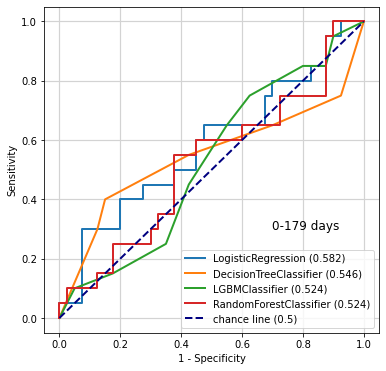

In [17]:
compute_matrics(joblib.load('predictions/predictions_6m.joblib'), '0-179 days')

,Algo,Threshold
0,VotingClassifier,0.58872
1,StackingClassifier_logistic,0.46721
2,StackingClassifier_rf,0.63000
3,StackingClassifier_lgbm,0.01864


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
3,StackingClassifier_lgbm,0.35000,0.50633,0.33898,1.00000,0.02500,0.36312
2,StackingClassifier_rf,0.65000,0.16000,0.40000,0.10000,0.92500,0.44437
0,VotingClassifier,0.65000,0.43243,0.47059,0.40000,0.77500,0.53125
1,StackingClassifier_logistic,0.70000,0.40000,0.60000,0.30000,0.90000,0.55000


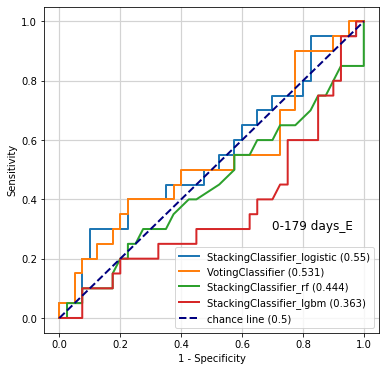

In [18]:
compute_matrics(joblib.load('predictions/preds_6_ensemble.joblib'), '0-179 days_E')

,Algo,Threshold
0,LogisticRegression,0.81082
1,DecisionTreeClassifier,0.65000
2,LGBMClassifier,0.32956
3,RandomForestClassifier,0.30952


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.75862,0.56250,0.69231,0.47368,0.89744,0.65047
1,DecisionTreeClassifier,0.60345,0.59649,0.44737,0.89474,0.46154,0.65722
2,LGBMClassifier,0.56897,0.57627,0.42500,0.89474,0.41026,0.68961
3,RandomForestClassifier,0.65517,0.60000,0.48387,0.78947,0.58974,0.69906


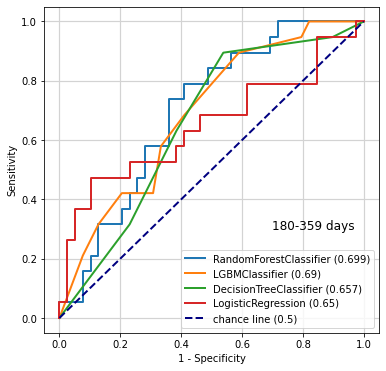

In [19]:
compute_matrics(joblib.load('predictions/predictions_12m.joblib'), '180-359 days')

,Algo,Threshold
0,VotingClassifier,0.46469
1,StackingClassifier_logistic,0.35328
2,StackingClassifier_rf,0.27000
3,StackingClassifier_lgbm,0.53271


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
3,StackingClassifier_lgbm,0.65517,0.37500,0.46154,0.31579,0.82051,0.48178
2,StackingClassifier_rf,0.51724,0.54839,0.39535,0.89474,0.33333,0.58637
1,StackingClassifier_logistic,0.72414,0.50000,0.61538,0.42105,0.87179,0.67341
0,VotingClassifier,0.60345,0.54902,0.43750,0.73684,0.53846,0.68151


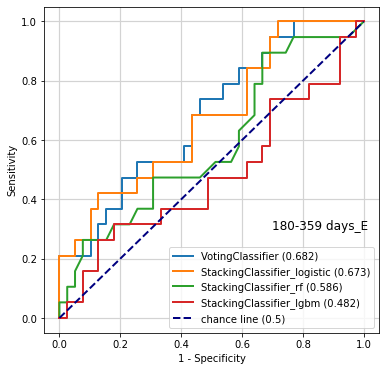

In [20]:
compute_matrics(joblib.load('predictions/preds_12_ensemble.joblib'), '180-359 days_E')

,Algo,Threshold
0,LogisticRegression,0.65305
1,DecisionTreeClassifier,0.66667
2,LGBMClassifier,0.33776
3,RandomForestClassifier,0.36875


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.63333,0.50000,0.45833,0.55000,0.67500,0.61625
3,RandomForestClassifier,0.75000,0.57143,0.66667,0.50000,0.87500,0.69563
2,LGBMClassifier,0.73333,0.60000,0.60000,0.60000,0.80000,0.70188
1,DecisionTreeClassifier,0.68333,0.62745,0.51613,0.80000,0.62500,0.73750


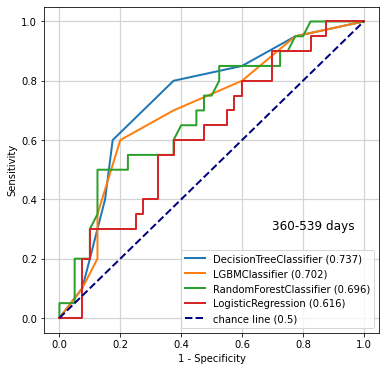

In [21]:
compute_matrics(joblib.load('predictions/predictions_18m.joblib'), '360-539 days')

,Algo,Threshold
0,VotingClassifier,0.49605
1,StackingClassifier_logistic,0.33589
2,StackingClassifier_rf,0.19000
3,StackingClassifier_lgbm,0.05223


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
3,StackingClassifier_lgbm,0.41667,0.52055,0.35849,0.95000,0.15000,0.41000
2,StackingClassifier_rf,0.45000,0.52174,0.36735,0.90000,0.22500,0.44000
1,StackingClassifier_logistic,0.70000,0.60870,0.53846,0.70000,0.70000,0.72000
0,VotingClassifier,0.71667,0.60465,0.56522,0.65000,0.75000,0.72250


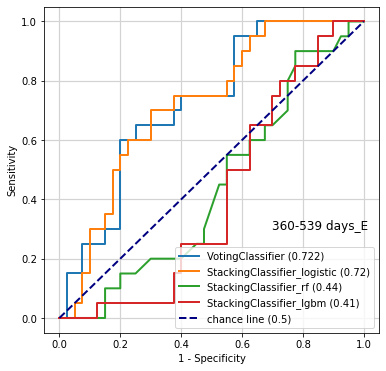

In [22]:
compute_matrics(joblib.load('predictions/preds_18_ensemble.joblib'), '360-539 days_E')

,Algo,Threshold
0,LogisticRegression,0.94431
1,DecisionTreeClassifier,0.68750
2,LGBMClassifier,0.99969
3,RandomForestClassifier,0.11875


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
3,RandomForestClassifier,0.45763,0.55556,0.38462,1.00000,0.17949,0.49551
1,DecisionTreeClassifier,0.59322,0.47826,0.42308,0.55000,0.61538,0.51346
0,LogisticRegression,0.72881,0.38462,0.83333,0.25000,0.97436,0.53333
2,LGBMClassifier,0.72881,0.38462,0.83333,0.25000,0.97436,0.54744


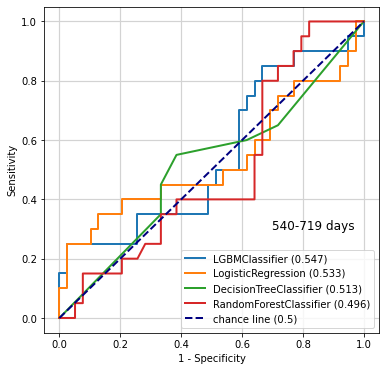

In [23]:
compute_matrics(joblib.load('predictions/predictions_24m.joblib'), '540-719 days')

,Algo,Threshold
0,VotingClassifier,0.68693
1,StackingClassifier_logistic,0.15341
2,StackingClassifier_rf,0.47000
3,StackingClassifier_lgbm,0.86698


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,VotingClassifier,0.64407,0.40000,0.46667,0.35000,0.79487,0.49872
1,StackingClassifier_logistic,0.44068,0.54795,0.37736,1.00000,0.15385,0.49872
3,StackingClassifier_lgbm,0.69492,0.30769,0.66667,0.20000,0.94872,0.50897
2,StackingClassifier_rf,0.67797,0.48649,0.52941,0.45000,0.79487,0.56090


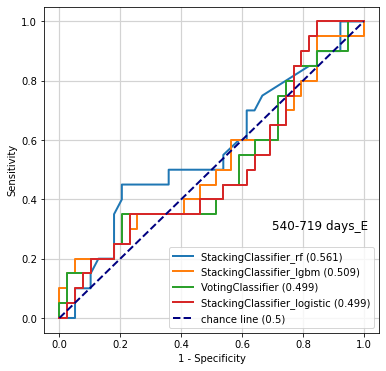

In [24]:
compute_matrics(joblib.load('predictions/preds_24_ensemble.joblib'), '540-719 days_E')